In [91]:
import os,sys
import pandas as pd
import numpy as np
import causality
import numpy
from causality.inference.search import IC
from causality.inference.independence_tests import RobustRegressionTest
import matplotlib.pyplot as plt
from causality.nonparametric.causal_reg import AdjustForDirectCauses
from networkx import DiGraph
import networkx as nx
from datetime import datetime
from anew_module import anew
%matplotlib inline

##### Question 
1. Does metrics from consecutive months form cause and effect pattern on each other

In [173]:
data.head()

,status_id,status_message,link_name,status_type,status_link,status_published,num_likes,num_comments,num_shares,date,Year,Month,Date
0,21898300328_10153621905210329,"Went to the kitchen to grab scissors, left wit...",33 Faces Everyone With ADD Will Immediately Re...,link,http://bzfd.it/1TDdJHZ,2015-07-19 16:01:00,5253,560,2554,2015-07-19,2015,07,19
1,21898300328_10153750673545329,"Warning: GRAPHIC, because, ya know, birth.",This Guy Recorded His Wife Giving Birth To A 1...,link,http://bzfd.it/1LgmaYc,2015-07-19 15:01:00,3408,655,1103,2015-07-19,2015,07,19
2,21898300328_10153723602000329,Two flower girls for the price of one!,This Adorable Dad Became The Flower Girl When ...,link,http://bzfd.it/1HW2emv,2015-07-19 14:31:01,828,24,26,2015-07-19,2015,07,19
3,21898300328_10153783767055329,"If you can't wear a regular band on the job, o...",28 Beautiful Alternatives For People Who Can’t...,link,http://bzfd.it/1e741O1,2015-07-19 14:03:27,3495,329,709,2015-07-19,2015,07,19
4,21898300328_10153715516145329,Keinen Bock mehr!\n\n(via BuzzFeed Deutschland),"17 Menschen, die einfach aufgegeben haben",link,http://www.buzzfeed.com/philippjahner/asdfghjk...,2015-07-19 13:48:01,79,6,11,2015-07-19,2015,07,19


#### Data
Data can be found on https://www.reddit.com/r/datasets/comments/3es1s4/33k_nytimes_and_18k_buzzfeed_facebook_posts_and_a/

Not the best ones - if you can find better for causal analysis - except for randomised standard data - let me
know too.

In [108]:
data = pd.read_csv('buzzfeed_facebook_statuses.csv')

In [110]:
data.columns

Index([u'status_id', u'status_message', u'link_name', u'status_type',
       u'status_link', u'status_published', u'num_likes', u'num_comments',
       u'num_shares'],
      dtype='object')

In [112]:
(data['num_likes']).describe()

count     18064.000000
mean       6091.658326
std       15430.495934
min           0.000000
25%         219.000000
50%        1733.000000
75%        6593.500000
max      943454.000000
Name: num_likes, dtype: float64

In [113]:
data[['Year','Month','Date']] = data['status_published'].apply(lambda x: pd.Series(x[:10].split('-')))

In [180]:
# take data only from the year 2015 and invert it - so is starts with the first day of 2015 in Jan
data1 = data[data['Year']=='2015'][::-1]

In [181]:
len_month_feeds = []
for i in range(1,8):
    # the feeds for all the rest months in the year are 0 in this data
    per_month = 'x'+str(i)
    globals()[per_month] = list(data1[data1['Month'] == '0'+str(i)]['num_likes'])
    len_month_feeds.append(len(globals()[per_month]))
    

In [184]:
# Just to have an equal length dataframe
# This would mean we only take a definite number of feeds from the start of the month
# This is not a correct way to check for causality as it forms the 
# directed graph with missing data in time and feeds
# But we proceed to try with RLM just to experiment 
min_n = min(len_month_feeds)
print min_n
print len_month_feeds

373
[703, 706, 932, 1005, 700, 634, 373]


In [185]:
X = pd.DataFrame({'x1' : x1[:min_n], 'x2' : x2[:min_n], 'x3' : x3[:min_n], 'x4' : x4[:min_n], 'x5' : x5[:min_n],\
                 'x6' : x6[:min_n], 'x7' : x7[:min_n]})

In [186]:
variable_types = {'x1' : 'c', 'x2' : 'c', 'x3' : 'c', 'x4' : 'c', 'x5' : 'c','x6' : 'c','x7' : 'c'}

# run the search
ic_algorithm = IC(RobustRegressionTest, X, variable_types)
graph = ic_algorithm.search()

In [187]:
graph.edges(data=True)

[('x2', 'x3', {'arrows': [], 'marked': False}),
 ('x2', 'x1', {'arrows': [], 'marked': False}),
 ('x2', 'x6', {'arrows': [], 'marked': False}),
 ('x2', 'x7', {'arrows': [], 'marked': False}),
 ('x2', 'x4', {'arrows': [], 'marked': False}),
 ('x2', 'x5', {'arrows': [], 'marked': False}),
 ('x3', 'x7', {'arrows': [], 'marked': False}),
 ('x3', 'x4', {'arrows': ['x4'], 'marked': False}),
 ('x3', 'x5', {'arrows': ['x5'], 'marked': False}),
 ('x1', 'x6', {'arrows': [], 'marked': False}),
 ('x1', 'x7', {'arrows': [], 'marked': False}),
 ('x1', 'x4', {'arrows': ['x4'], 'marked': False}),
 ('x1', 'x5', {'arrows': ['x5'], 'marked': False}),
 ('x6', 'x7', {'arrows': [], 'marked': False}),
 ('x6', 'x4', {'arrows': ['x6'], 'marked': True}),
 ('x6', 'x5', {'arrows': ['x6'], 'marked': True}),
 ('x7', 'x4', {'arrows': [], 'marked': False}),
 ('x7', 'x5', {'arrows': [], 'marked': False}),
 ('x4', 'x5', {'arrows': [], 'marked': False})]

In [188]:
# This gives true causal inference between the month (april and june) and (may and june)
# In a sense they form a subset collider
# not a true collider as they have other parent nodes too

In [189]:
to_plot = map(lambda x: (x[0],x[1]) if (x[2]['arrows']!=[]) else (x[1],x[0]),graph.edges(data=True))

In [190]:
to_plot

[('x3', 'x2'),
 ('x1', 'x2'),
 ('x6', 'x2'),
 ('x7', 'x2'),
 ('x4', 'x2'),
 ('x5', 'x2'),
 ('x7', 'x3'),
 ('x3', 'x4'),
 ('x3', 'x5'),
 ('x6', 'x1'),
 ('x7', 'x1'),
 ('x1', 'x4'),
 ('x1', 'x5'),
 ('x7', 'x6'),
 ('x6', 'x4'),
 ('x6', 'x5'),
 ('x4', 'x7'),
 ('x5', 'x7'),
 ('x5', 'x4')]

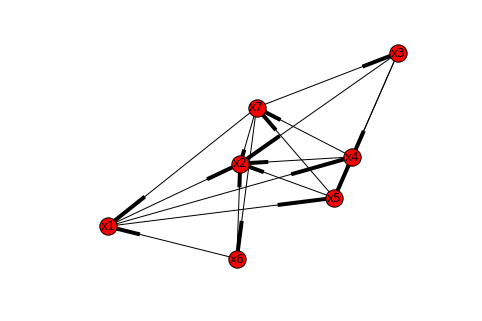

In [191]:
from causality.nonparametric.causal_reg import AdjustForDirectCauses
from networkx import DiGraph

g = DiGraph()

g.add_nodes_from(['x1','x2','x3','x4', 'x5','x6','x7'])
g.add_edges_from([('x3', 'x2'),('x1', 'x2'),('x6', 'x2'),('x7', 'x2'),('x4', 'x2'),('x5', 'x2'),('x7', 'x3'),\
                  ('x3', 'x4'),('x3', 'x5'),('x6', 'x1'),('x7', 'x1'),('x1', 'x4'),('x1', 'x5'),('x7', 'x6'),\
                  ('x4', 'x7'),('x5', 'x7'),('x5', 'x4')])
nx.draw(g,with_labels = True)

In [192]:
# Not the best way for an analysis - but playing around for now